## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.utils import read_config,plot_correlation_matrix,plot_distribution,box_plot,scatter_plot

from sklearn.preprocessing import StandardScaler
from scipy.cluster._hierarchy import linkage, dendrogram
pd.set_option('display.max_columns', None)

## Explore Data

In [2]:
config = read_config()
segmentation_path = os.path.join(os.getcwd(),"..","Data" ,config["filenames"]["segmentation"])
df = pd.read_csv(segmentation_path, index_col=0)
df.head()


c:\Users\satwik.boina\Documents\git_clones\CustomerAnalytics\src\..


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


- We don't need ID for modelling
- Age and Income should be scaled to ignore the bias 
- Occupation, Education and Settlement size are Ordinal categorical variables
- Marital Status and Sex are Binary categorical variables.

In [3]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [4]:
df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

### Plotting

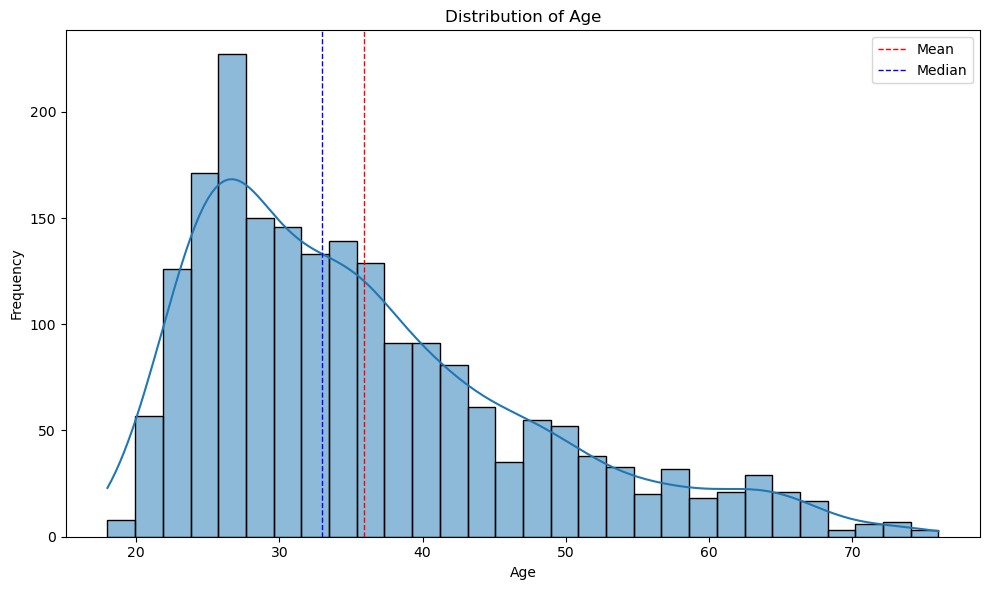

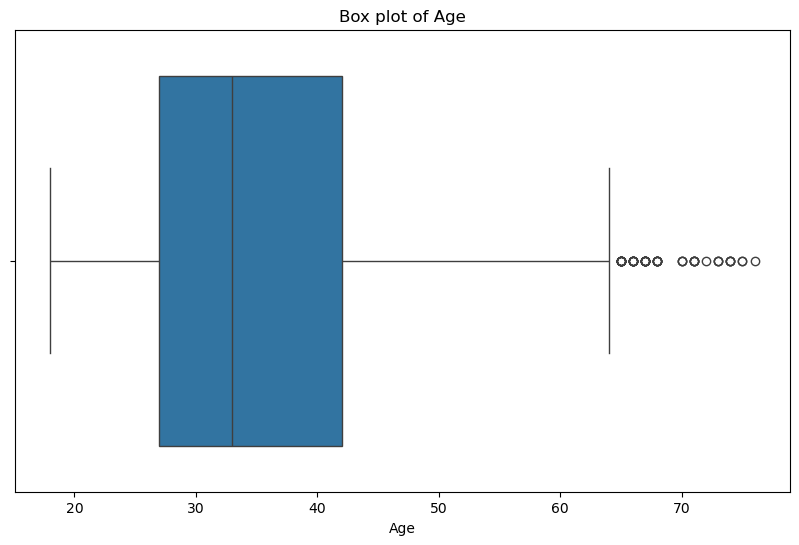

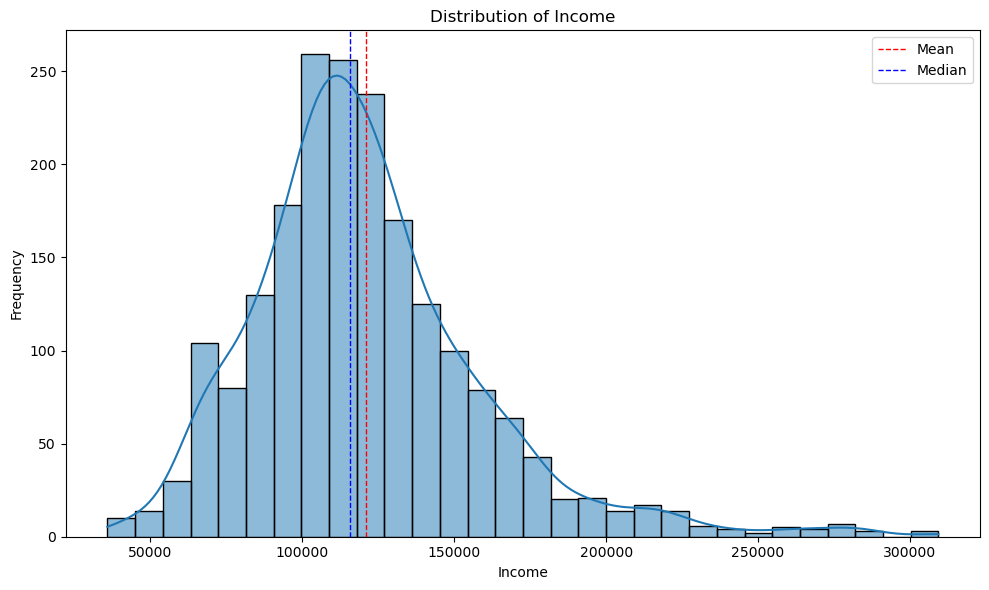

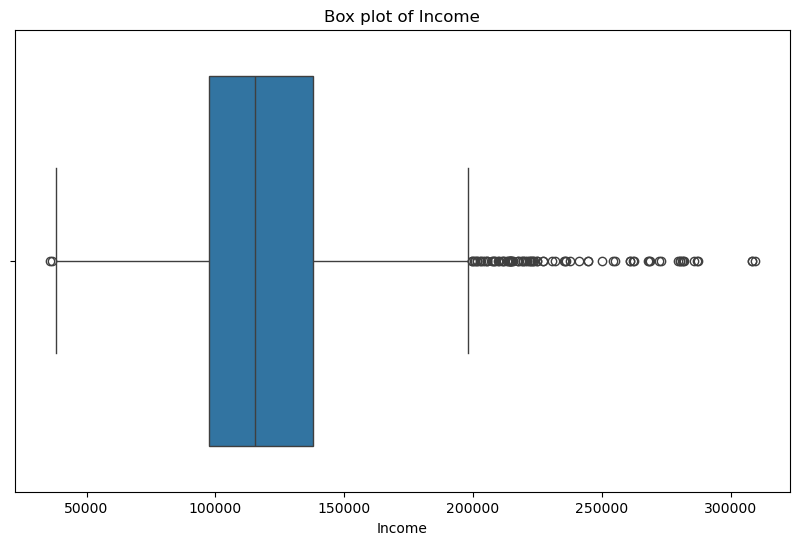

In [5]:
univariate_cols = ["Age","Income"]
for col in univariate_cols:
    plot_distribution(df, col, title=f"Distribution of {col}")
    box_plot(df, col, title=f"Box plot of {col}")


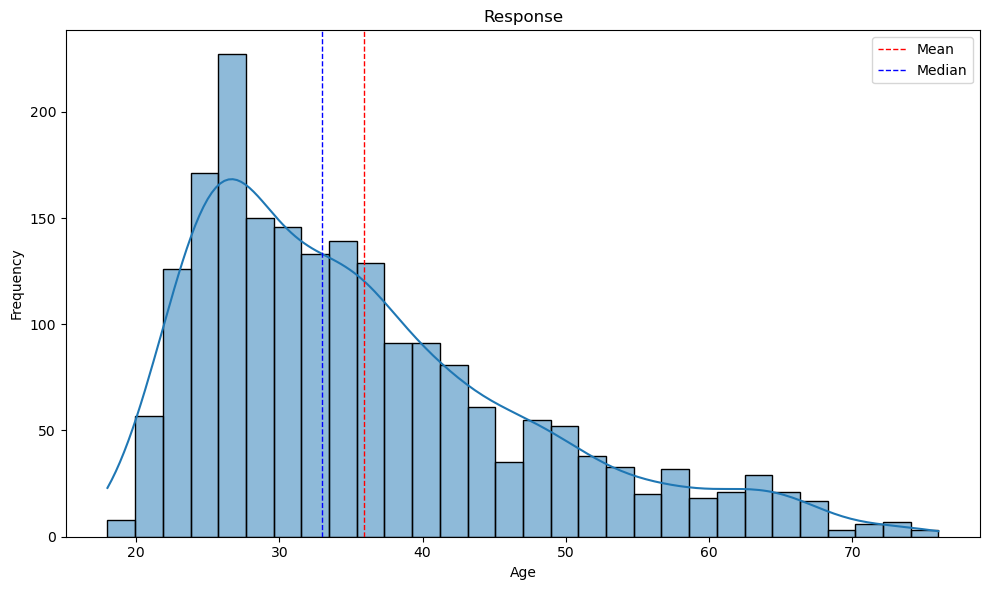

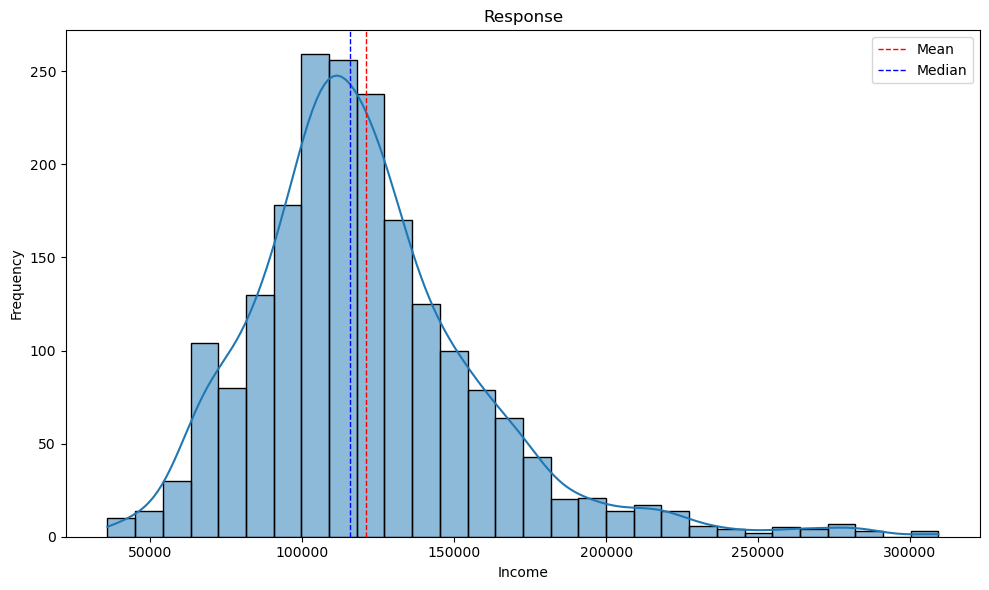

In [6]:
plot_distribution(df, "Age", "Response")
plot_distribution(df, "Income", "Response")

- Age is right skewed which means the dataset has a lot of young customers.
- Income is almost normal except some slight skewness towards right.
- Mean and Median of income is pretty close.

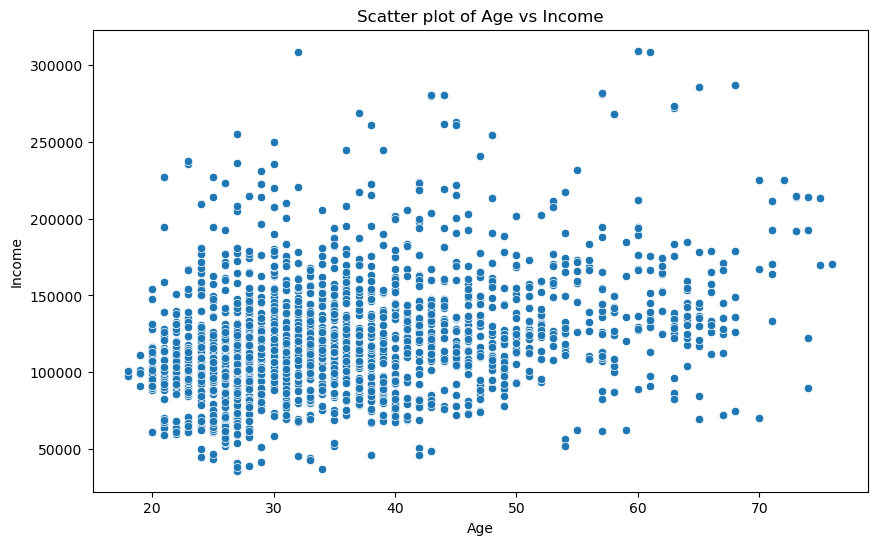

In [7]:
scatter_plot_pairs = [("Age", "Income")]

for x, y in scatter_plot_pairs:
    scatter_plot(df, x, y, title=f"Scatter plot of {x} vs {y}")

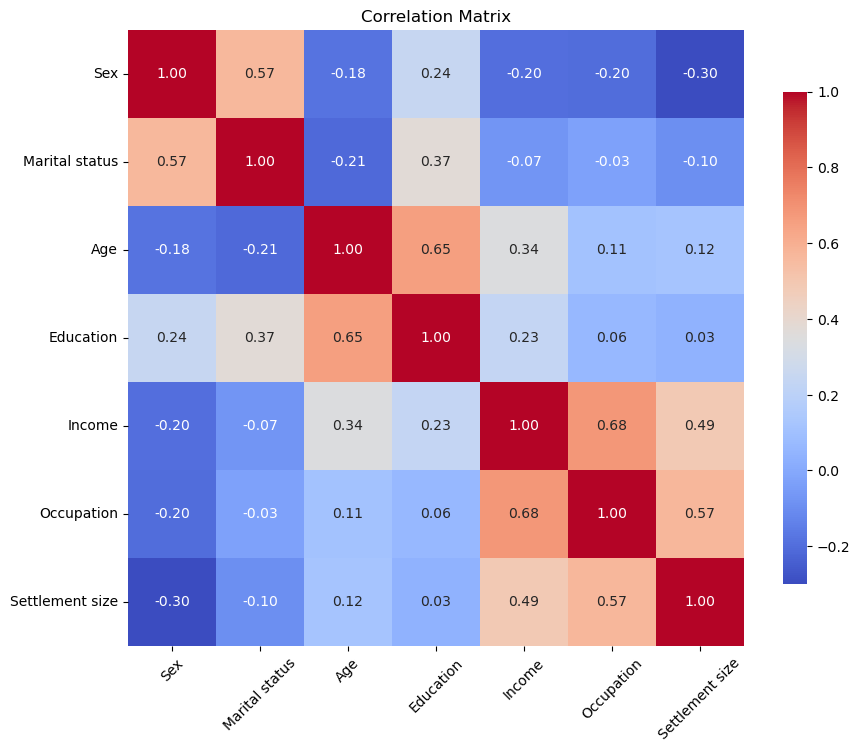

In [8]:
plot_correlation_matrix(df, title="Correlation Matrix")

- High correlation between Age and Education, Occupation and Income

## Standardization of Age and Income

In [9]:
scaler = StandardScaler()
cols_to_scale = ["Age", "Income"]
columns = df.columns.tolist()
# but we will scale all columns for consistency
data = scaler.fit_transform(df)
